In [19]:
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
data = pd.read_csv('D:/Coding/Github/automatic_parking/vision_assisted_autonomous_parking/datasets/dataset_completo.csv')
x = data.iloc[:, :720].values.astype(dtype=np.float32)
y = data.iloc[:, 720].values.astype(dtype=np.int64) 
feature_index = list(range(0,720))
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

xs_train = torch.tensor(X_train).view(-1, len(X_train[0])).to(device)
ys_train = torch.tensor(y_train).to(device)
xs_test = torch.tensor(X_test).view(-1, len(X_test[0])).to(device)
ys_test = torch.tensor(y_test).to(device)

NVIDIA GeForce RTX 3060 Laptop GPU


In [23]:
max_value = 12          #Ver
min_value = 0

xs_train_min_max = (xs_train - min_value)/(max_value - min_value)
xs_test_min_max = (xs_test - min_value)/(max_value - min_value)

In [25]:
class AlexNet1D(nn.Module):
    def __init__(self, num_classes=4):
        super(AlexNet1D, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool1d(6)
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [26]:
model = AlexNet1D(4)
model.to(device)
batch_size = 32
torch.manual_seed(42)
dataset = TensorDataset(xs_train_min_max.unsqueeze(1),ys_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [28]:
num_epochs = 1000
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_per_epoch = []
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
    loss_per_epoch.append(loss.item())

print('Finished Training')

Epoch [1/1000], Loss: 1.4003442525863647
Epoch [2/1000], Loss: 1.3851693868637085
Epoch [3/1000], Loss: 1.392391324043274
Epoch [4/1000], Loss: 1.369356393814087
Epoch [5/1000], Loss: 1.3819330930709839
Epoch [6/1000], Loss: 1.3920233249664307
Epoch [7/1000], Loss: 0.6477178335189819
Epoch [8/1000], Loss: 0.6741153001785278
Epoch [9/1000], Loss: 0.021683666855096817
Epoch [10/1000], Loss: 0.07255369424819946
Epoch [11/1000], Loss: 0.05204121768474579
Epoch [12/1000], Loss: 0.01827477663755417
Epoch [13/1000], Loss: 0.009948519989848137
Epoch [14/1000], Loss: 0.00658743642270565
Epoch [15/1000], Loss: 0.019723834469914436
Epoch [16/1000], Loss: 0.02904581092298031
Epoch [17/1000], Loss: 0.0928652286529541
Epoch [18/1000], Loss: 0.003516055876389146
Epoch [19/1000], Loss: 0.017927933484315872
Epoch [20/1000], Loss: 0.011871764436364174
Epoch [21/1000], Loss: 0.004987366497516632
Epoch [22/1000], Loss: 0.006874830927699804
Epoch [23/1000], Loss: 0.03023798018693924
Epoch [24/1000], Loss: 

In [29]:
with torch.no_grad():
    outputs = model(xs_test_min_max.unsqueeze(1))
_, predicted = torch.max(outputs, 1)
accuracy = (predicted == ys_test).sum().item() / ys_test.size(0)

print(f"Loss: {loss.item()}")
print(f"Accuracy: {accuracy}")

Loss: 2.384185648907078e-08
Accuracy: 0.9994015559545183


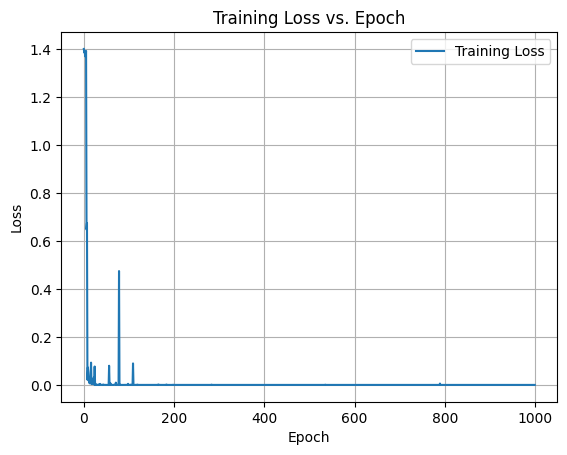

In [32]:
plt.plot(range(0,1000), loss_per_epoch, label='Training Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [36]:
model.eval()
with torch.no_grad():
    predicted_value = model(torch.tensor((xs_test_min_max[3].unsqueeze(0)).unsqueeze(0)).to(device))
print("Input Feature: " + str(xs_test_min_max[3]))
print("Expected Value: " + str(ys_test[3]))
print("Model Output: " + str(predicted_value))
print("Model Prediction: " + str(torch.argmax(predicted_value)))

C:\Users\gsoch\AppData\Local\Temp\ipykernel_8084\2148181974.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_value = model(torch.tensor((xs_test_min_max[3].unsqueeze(0)).unsqueeze(0)).to(device))


Input Feature: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0153, 0.0153, 0.0154, 0.0154,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1488, 0.1488, 0.1497, 0.1497,
        0.2037, 0.2040, 0.2047, 0.2053, 0.2060, 0.2067, 0.2073, 0.2080, 0.2087,
        0.2090, 0.2097, 0.2097, 0.2107, 0.2117, 0.2123, 0.2123, 0.2097, 0.2150,
        0.2150, 0.2073, 0.2073, 0.2003, 0.2003, 0.1977, 0.1937, 0.1920, 0.1877,
        0.1850, 0.1853, 0.1863, 0.1867, 0.1747, 0.1747, 0.1720, 0.1697, 0.1678,
        0.1660, 0.1650, 0.1625, 0.1607, 0.1597, 0.1580, 0.1570, 0.1568, 0.1577,
        0.1593, 0.1598, 0.1910, 0.1900, 0.1890, 0.1877, 0.1847, 0.1830, 0.1820,
        0.1793, 0.1783, 0.1770, 0.1760, 0.1737, 0.1727, 0.1710, 0.1695, 0.1687,
        0.1670, 0.1662, 0.1645, 0.1632, 0.1623, 0.1605, 0.1598, 0.1587, 0.1580,
        0.1563, 0.1552, 0

In [37]:
torch.save(model.state_dict(), 'D:/Coding/Github/automatic_parking/vision_assisted_autonomous_parking/Pytorch/model/model_final.pth')

In [44]:
model = AlexNet1D(4)
model.load_state_dict(torch.load('D:/Coding/Github/automatic_parking/vision_assisted_autonomous_parking/Pytorch/model/model_final.pth'))
model.to(device)
model.eval()

AlexNet1D(
  (features): Sequential(
    (0): Conv1d(1, 64, kernel_size=(11,), stride=(4,), padding=(2,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 192, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU(inplace=True)
    (5): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(192, 384, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU(inplace=True)
    (8): Conv1d(384, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): ReLU(inplace=True)
    (10): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): ReLU(inplace=True)
    (12): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool1d(output_size=6)
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1536, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3)

In [46]:
with torch.no_grad():
    predicted_value = model(torch.tensor(xs_test[1000].unsqueeze(0).unsqueeze(0)).to(device))
#print("Input Feature: " + str(xs_test[1000]))
print("Expected Value: " + str(ys_test[1000]))
print("Model Prediction: " + str(torch.argmax(predicted_value)))

Expected Value: tensor(0, device='cuda:0')
Model Prediction: tensor(0, device='cuda:0')


C:\Users\gsoch\AppData\Local\Temp\ipykernel_8084\1265031259.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_value = model(torch.tensor(xs_test[1000].unsqueeze(0).unsqueeze(0)).to(device))
